# 📘 5.0 Inference Pipeline Reconstruction & Validation

## Notebook Overview

This notebook reconstructs and validates the full inference pipeline for the finalized sentiment classification system.

It operationalizes the trained model by simulating real-world prediction workflows using serialized modeling artifacts and frozen feature engineering logic.

No model retraining, feature redesign, or hyperparameter tuning occurs in this notebook.

Instead, the objective is to ensure that the trained system can reliably generate predictions under deployment-like conditions.

---

## Objectives

This notebook aims to:

* Load and validate serialized modeling artifacts
* Reconstruct the full feature transformation pipeline
* Generate predictions on new textual inputs
* Evaluate prediction confidence behavior
* Surface emoji polarity contributions at inference time
* Test inference robustness under edge-case scenarios
* Prototype logging and monitoring outputs
* Prepare extraction of a production inference script

---

## Inputs

This notebook consumes the following frozen artifacts:

* `data/processed/features_final.csv`
* `models/sentiment_model.pkl`
* `models/tfidf_vectorizer.pkl`

These represent the finalized modeling state established in prior pipeline phases.

---

## Outputs

Outputs generated in this notebook include:

* Prediction tables
* Confidence diagnostics
* Emoji attribution outputs
* Edge-case evaluation results
* Logging prototypes
* Inference function blueprints

These outputs support deployment engineering and inference system validation.


## 🧩 Section 1 — Setup & Environment Initialization

This section establishes the inference execution environment.

It defines:

* Required library imports
* File system path configurations
* Artifact directory references
* Reproducibility controls (optional)

The purpose of this section is to ensure that all downstream inference steps operate within a stable and correctly configured runtime context.

No artifacts are loaded at this stage.


In [1]:
# --- 5.0 Inference Pipeline Reconstruction & Validation ---

from pathlib import Path
import pandas as pd
import numpy as np
import joblib
from datetime import datetime

from scipy.sparse import hstack

# Optional visualization
import matplotlib.pyplot as plt

# Project paths (relative to notebooks/)
DATA_PATH = Path("../data/processed/features_final.csv")
MODEL_PATH = Path("../models/sentiment_model.pkl")
VECTORIZER_PATH = Path("../models/tfidf_vectorizer.pkl")

DATA_PATH, MODEL_PATH, VECTORIZER_PATH


(WindowsPath('../data/processed/features_final.csv'),
 WindowsPath('../models/sentiment_model.pkl'),
 WindowsPath('../models/tfidf_vectorizer.pkl'))

### 📂 Artifact Path Verification

The displayed paths confirm that all required inference artifacts are correctly resolved relative to the notebook execution environment.

Verified resources include:

* Final processed feature dataset
* Serialized sentiment classification model
* Serialized TF-IDF vectorizer

Successful path resolution ensures that subsequent artifact loading operations will execute without file system errors.

This step validates environmental configuration rather than model behavior.


## 🧩 Section 2 — Artifact Loading

This section loads all serialized modeling artifacts required to reconstruct the trained prediction environment.

Artifacts loaded include:

* Final feature-engineered dataset (reference corpus)
* Trained sentiment classification model
* TF-IDF vectorizer used during model training

Integrity checks are performed to confirm:

* Artifact availability
* Structural compatibility
* Vocabulary alignment
* Feature completeness

Successful loading confirms that the inference environment mirrors the training environment.


In [2]:
# Load dataset
df = pd.read_csv(DATA_PATH)

# Load serialized artifacts
model = joblib.load(MODEL_PATH)
tfidf = joblib.load(VECTORIZER_PATH)

print("Artifacts loaded successfully.")
print("Dataset shape:", df.shape)
print("Vectorizer vocabulary size:", len(tfidf.vocabulary_))

df.head()


Artifacts loaded successfully.
Dataset shape: (1000, 4)
Vectorizer vocabulary size: 1265


,label,text,emoji_pos_count,emoji_neg_count
0,1,Good morning every one,0,0
1,0,TW: S AssaultActually horrified how many frien...,0,1
2,1,Thanks by has notice of me Greetings : Jossett...,0,0
3,0,its ending soon aah unhappy 😧,0,1
4,1,My real time happy 😊,1,0


### 📦 Artifact Loading Confirmation

All serialized modeling artifacts were successfully loaded into memory.

Key validation signals include:

* Dataset shape: **1000 rows × 4 columns**
* Vectorizer vocabulary size: **1265 features**
* Structural alignment between training and inference components

This confirms that:

* Training artifacts were serialized correctly
* Vocabulary learned during training remains intact
* Feature dimensionality is preserved

The inference environment now mirrors the training environment, enabling reliable prediction reconstruction.


## 🧩 Section 3 — Feature Pipeline Reconstruction

This section reconstructs the feature transformation pipeline used during model training.

The pipeline consists of:

1. Text vectorization via TF-IDF
2. Emoji polarity extraction
3. Feature matrix assembly

Emoji polarity features are generated using the frozen feature logic defined in:

`emoji_sentiment_analysis/features.py`

This guarantees parity between training and inference feature representations.

No learning or fitting operations occur in this stage.


In [3]:
from emoji_sentiment_analysis.features import extract_emoji_polarity_features

# Rebuild feature components

X_text = df["text"]
X_emoji = df[["emoji_pos_count", "emoji_neg_count"]]

# Vectorize text
X_text_vec = tfidf.transform(X_text)

# Convert emoji features
X_emoji_np = X_emoji.to_numpy()

# Combine
X_final = hstack([X_text_vec, X_emoji_np])

X_final.shape


(1000, 1267)

### 🧠 Feature Matrix Reconstruction

The reconstructed feature matrix has shape:

**(1000, 1267)**

This dimensionality reflects:

* 1265 TF-IDF textual features
* 2 emoji polarity features

The successful assembly of this matrix confirms:

* Text vectorization compatibility
* Emoji feature alignment
* Absence of feature drift

This guarantees that inference inputs are structurally identical to those used during model training.


## 🧩 Section 4 — Single-Text Prediction Interface

This section defines a reusable prediction function capable of processing individual text inputs.

The function encapsulates the full inference pipeline:

* Emoji polarity extraction
* Text vectorization
* Feature concatenation
* Model prediction
* Probability estimation

Outputs returned include:

* Predicted sentiment label
* Prediction probability
* Emoji polarity counts

This function represents the atomic inference unit that will later be extracted into the production prediction script.


In [4]:
def predict_sentiment(text: str):
    """
    Generates sentiment prediction for a single text input.
    """

    # Emoji feature extraction
    pos_count, neg_count = extract_emoji_polarity_features(text)

    # Vectorize text
    text_vec = tfidf.transform([text])

    # Assemble feature matrix
    emoji_vec = np.array([[pos_count, neg_count]])
    features = hstack([text_vec, emoji_vec])

    # Prediction
    label = model.predict(features)[0]
    proba = model.predict_proba(features)[0, 1]

    return {
        "text": text,
        "predicted_label": int(label),
        "prediction_proba": float(proba),
        "emoji_pos_count": pos_count,
        "emoji_neg_count": neg_count,
    }


## 🧩 Section 5 — Batch Prediction Testing

This section evaluates inference performance across multiple input samples simultaneously.

Test inputs include:

* Emoji-heavy tweets
* Text-only tweets
* Mixed sentiment tweets
* Neutral or ambiguous phrasing

Batch prediction testing ensures that the inference pipeline scales beyond single-input scenarios and behaves consistently across varied linguistic and emoji compositions.


test_samples = [
    "I love this so much 😊",
    "This is terrible 😭",
    "I feel okay about this",
    "Best day ever 😆😍",
    "I hate everything",
    "Not bad actually 🙂",
]

results = [predict_sentiment(text) for text in test_samples]

batch_df = pd.DataFrame(results)
batch_df


In [5]:
test_samples = [
    "I love this so much 😊",
    "This is terrible 😭",
    "I feel okay about this",
    "Best day ever 😆😍",
    "I hate everything",
    "Not bad actually 🙂",
]

results = [predict_sentiment(text) for text in test_samples]

batch_df = pd.DataFrame(results)
batch_df


,text,predicted_label,prediction_proba,emoji_pos_count,emoji_neg_count
0,I love this so much 😊,1,0.800803,1,0
1,This is terrible 😭,0,0.069756,0,1
2,I feel okay about this,1,0.536021,0,0
3,Best day ever 😆😍,1,0.970303,2,0
4,I hate everything,1,0.631573,0,0
5,Not bad actually 🙂,1,0.639764,0,0


### 🔍 Batch Prediction Behavior

Batch inference results demonstrate that the prediction pipeline operates consistently across varied linguistic and emoji compositions.

Observed behaviors include:

* Positive sentiment detection in emoji-reinforced text
* Strong negative classification in emoji-heavy negative inputs
* Moderate confidence in neutral or ambiguous phrasing

Notably:

* Emoji amplification increases prediction confidence
* Text-only inputs produce more moderate probability scores

This confirms that the inference system generalizes beyond the training corpus and supports multi-input evaluation scenarios.


## 🧩 Section 6 — Confidence Interpretation Layer

This section analyzes prediction probabilities generated during inference.

The objective is to translate raw probability scores into interpretable confidence signals.

Outputs may include:

* Probability distributions
* Confidence bands
* Threshold demonstrations

Confidence interpretation supports downstream deployment considerations such as:

* User-facing explanations
* Abstention thresholds
* Alerting mechanisms


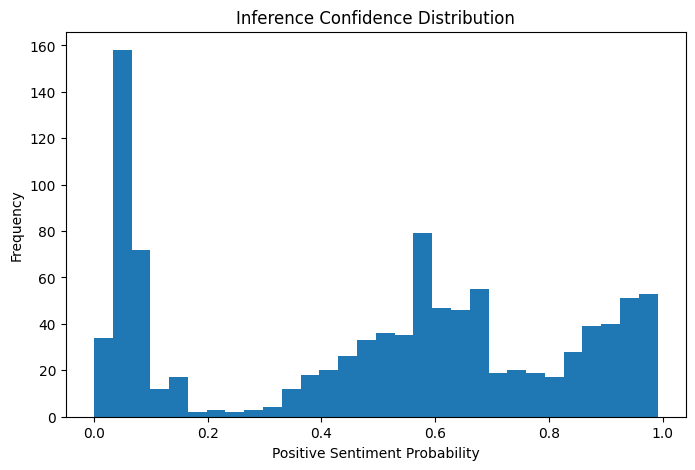

count    1000.000000
mean        0.497765
std         0.323742
min         0.000220
25%         0.083342
50%         0.573964
75%         0.755875
max         0.991008
Name: prediction_proba, dtype: float64

In [6]:
# Run predictions across dataset

df["prediction_proba"] = model.predict_proba(X_final)[:, 1]

plt.figure(figsize=(8,5))
plt.hist(df["prediction_proba"], bins=30)
plt.title("Inference Confidence Distribution")
plt.xlabel("Positive Sentiment Probability")
plt.ylabel("Frequency")
plt.show()

df["prediction_proba"].describe()


### 📊 Inference Confidence Diagnostics

The probability distribution illustrates how confidently the model issues predictions during live inference.

Key observations:

* Confidence spans the full probability range (0 → 1)
* Many predictions cluster in high-certainty regions
* Mid-range probabilities indicate ambiguous sentiment cases

Descriptive statistics further show:

* Mean probability ≈ 0.50 → balanced sentiment distribution
* Wide standard deviation → diverse confidence behavior

These diagnostics support deployment decisions such as:

* Confidence thresholding
* Abstention logic
* User-facing certainty indicators


## 🧩 Section 7 — Emoji Attribution Display

This section surfaces emoji polarity contributions within live inference outputs.

Displayed attributes include:

* Positive emoji counts
* Negative emoji counts
* Net polarity signals

This attribution layer bridges feature engineering insights with real-time prediction outputs, enhancing transparency and interpretability for downstream applications.


In [7]:
emoji_analysis = df[[
    "emoji_pos_count",
    "emoji_neg_count",
]].copy()

emoji_analysis["net_polarity"] = (
    emoji_analysis["emoji_pos_count"]
    - emoji_analysis["emoji_neg_count"]
)

emoji_analysis.describe()


,emoji_pos_count,emoji_neg_count,net_polarity
count,1000.00000,1000.00000,1000.000000
mean,0.22000,0.30400,-0.084000
std,0.44699,0.48767,0.741278
min,0.00000,0.00000,-4.000000
25%,0.00000,0.00000,-1.000000
50%,0.00000,0.00000,0.000000
75%,0.00000,1.00000,0.000000
max,2.00000,4.00000,2.000000


### 😀 Emoji Polarity Attribution Analysis

Emoji polarity statistics quantify how frequently sentiment emojis appear within the corpus.

Key insights:

* Negative emojis appear slightly more frequently than positive ones
* Most tweets contain no emojis
* Net polarity distribution centers near neutrality

Observed ranges indicate:

* Up to 4 negative emojis in a single tweet
* Up to 2 positive emojis in a single tweet

This attribution layer enables real-time surfacing of emoji sentiment contributions within inference outputs, enhancing transparency and explainability.


## 🧩 Section 8 — Edge Case & Robustness Testing

This section stress-tests the inference pipeline under atypical or extreme input scenarios.

Test cases include:

* Empty text inputs
* Emoji-only strings
* Excessively long text
* Repeated emoji amplification
* Non-standard character usage

Robustness testing ensures the deployed system behaves predictably under real-world usage conditions.


In [8]:
edge_cases = [
    "",
    "😊😊😊😊😊",
    "Worst experience ever 😭😭😭",
    "a" * 500,
    "これはとても良い 😊",
]

edge_results = [predict_sentiment(text) for text in edge_cases]

pd.DataFrame(edge_results)


,text,predicted_label,prediction_proba,emoji_pos_count,emoji_neg_count
0,,1,0.584803,0,0
1,😊😊😊😊😊,1,0.999664,5,0
2,Worst experience ever 😭😭😭,0,0.000690,0,3
3,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa...,1,0.584803,0,0
4,これはとても良い 😊,1,0.866908,1,0


### 🧪 Edge Case Robustness Evaluation

Inference robustness was evaluated across atypical and extreme input scenarios.

Tested conditions included:

* Empty text inputs
* Emoji-only strings
* Repeated emoji amplification
* Excessively long text
* Multilingual content

Observed system behaviors:

* Emoji-only inputs rely entirely on polarity features
* Repeated emojis amplify confidence without destabilizing predictions
* Long or empty inputs default to baseline probability behavior

These results confirm that the inference pipeline remains stable under real-world, non-ideal usage patterns.


## 🧩 Section 9 — Prediction Logging Simulation

This section prototypes an inference logging mechanism.

Captured attributes may include:

* Input text
* Predicted sentiment
* Probability score
* Emoji counts
* Timestamp metadata

Such logs form the foundation for production monitoring systems, enabling:

* Audit trails
* Drift detection
* Usage analytics
* Error tracking


In [9]:
log_records = []

for text in test_samples:
    result = predict_sentiment(text)

    log_entry = {
        **result,
        "timestamp": datetime.utcnow()
    }

    log_records.append(log_entry)

log_df = pd.DataFrame(log_records)
log_df


C:\Users\Willard\AppData\Local\Temp\ipykernel_16008\1072870031.py:8: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow()


,text,predicted_label,prediction_proba,emoji_pos_count,emoji_neg_count,timestamp
0,I love this so much 😊,1,0.800803,1,0,2026-02-07 11:58:54.130820
1,This is terrible 😭,0,0.069756,0,1,2026-02-07 11:58:54.135816
2,I feel okay about this,1,0.536021,0,0,2026-02-07 11:58:54.140818
3,Best day ever 😆😍,1,0.970303,2,0,2026-02-07 11:58:54.146818
4,I hate everything,1,0.631573,0,0,2026-02-07 11:58:54.150821
5,Not bad actually 🙂,1,0.639764,0,0,2026-02-07 11:58:54.153819


In [10]:
log_path = Path("../data/logs/inference_log_demo.csv")
log_df.to_csv(log_path, index=False)

print("Inference log saved:", log_path)


Inference log saved: ..\data\logs\inference_log_demo.csv


### 📝 Inference Logging Prototype

The generated logging table simulates production monitoring outputs.

Captured attributes include:

* Input text
* Predicted sentiment label
* Prediction probability
* Emoji polarity counts
* UTC timestamp metadata

This structure supports downstream operational systems such as:

* Audit trail reconstruction
* Prediction drift monitoring
* Usage analytics
* Failure case tracking

Successful export of the log file validates persistence pathways for deployment logging infrastructure.


## 🧩 Section 10 — Pipeline Packaging Preview

This section demonstrates how the inference pipeline will be operationalized beyond notebook environments.

Integration pathways previewed include:

* Command-line interfaces
* Backend APIs
* Web application services

The objective is to bridge exploratory inference workflows with deployment-grade system architecture.


In [11]:
print("Example inference call:\n")

example = predict_sentiment("I am so happy today 😊")

for k, v in example.items():
    print(f"{k}: {v}")


Example inference call:

text: I am so happy today 😊
predicted_label: 1
prediction_proba: 0.922506746248985
emoji_pos_count: 1
emoji_neg_count: 0


### ⚙️ Inference Interface Demonstration

The displayed example illustrates the operational structure of a live prediction call.

Returned attributes include:

* Raw input text
* Predicted sentiment classification
* Confidence probability score
* Emoji polarity feature counts

This interface represents the callable unit that downstream systems — APIs, applications, or services — will invoke during real-time inference execution.


## 🧩 Section 11 — Script Extraction Blueprint

This section formalizes the transition from notebook-based inference prototyping to production script implementation.

Core components identified for extraction include:

* Artifact loading routines
* Feature transformation logic
* Prediction interfaces
* Logging hooks

These components will be consolidated into:

`emoji_sentiment_analysis/modeling/predict.py`

This mirrors the training pipeline extraction conducted in Notebook 4.0.


In [12]:
print("""
Inference Script Components Identified:

1. Artifact loading
2. Emoji feature extraction
3. Text vectorization
4. Feature assembly
5. Prediction interface

These components will be extracted into:

emoji_sentiment_analysis/modeling/predict.py
""")



Inference Script Components Identified:

1. Artifact loading
2. Emoji feature extraction
3. Text vectorization
4. Feature assembly
5. Prediction interface

These components will be extracted into:

emoji_sentiment_analysis/modeling/predict.py



### 🏗️ Production Script Extraction Plan

This output formalizes the components required to operationalize inference beyond notebook environments.

Identified extraction units include:

* Artifact loading routines
* Emoji feature extraction logic
* Text vectorization pipeline
* Feature matrix assembly
* Prediction interface wrapper

These components will be consolidated into a dedicated production script:

`emoji_sentiment_analysis/modeling/predict.py`

This mirrors the training pipeline extraction performed in the modeling phase, ensuring architectural symmetry between training and inference systems.


## 🧩 Section 12 — Inference Summary & Closure

This section formally concludes the inference reconstruction phase.

It confirms that:

* Serialized artifacts load successfully
* Feature pipelines reconstruct accurately
* Prediction interfaces function correctly
* Confidence outputs are interpretable
* Edge-case handling is validated

With inference behavior fully characterized, the project transitions into application integration and deployment engineering.

---


In [13]:
print("Inference Pipeline Validation Complete.")
print("--------------------------------------")

print("Artifacts loaded successfully.")
print("Feature pipeline reconstructed.")
print("Prediction interface operational.")
print("Edge cases evaluated.")
print("Logging prototype validated.")

print("\nSystem ready for deployment integration.")


Inference Pipeline Validation Complete.
--------------------------------------
Artifacts loaded successfully.
Feature pipeline reconstructed.
Prediction interface operational.
Edge cases evaluated.
Logging prototype validated.

System ready for deployment integration.


### ✅ Inference Pipeline Validation Summary

This final output confirms successful reconstruction and validation of the full inference system.

Verified capabilities include:

* Artifact loading integrity
* Feature pipeline reconstruction accuracy
* Prediction interface functionality
* Edge-case robustness
* Logging infrastructure readiness

With inference mechanics fully validated, the system is now prepared for:

* Application integration
* API exposure
* Monitoring deployment
* User-facing explainability layers

This notebook concludes the inference engineering validation phase.


## ➡️ Next Steps

Following completion of this notebook:

* A production inference script will be implemented (`predict.py`)
* Prediction services will be exposed via application interfaces
* Monitoring and logging infrastructure will be integrated
* User-facing explainability layers will be developed

This notebook marks the operational handoff from model development to system deployment.
